<center><img src="header.png" width = "800"/></center>

### <b> InSAR Coherent Change Detection over Aleppo, Syria (April 17-29, 2016)
    
<b><i> Corey Scher<sup>1</sup>
<i>Jamon Van Den Hoek<sup>2</sup>
    
<i><font size=2> 1. Department of Earth and Environmental Sciences | Graduate Center at the City University of New York
    
<i><font size=2> 2. College of Earth, Ocean, and Atmospheric Sciences | Oregon State University

<span style="font-size: 16pt"> **Part two**: bi-temporal change detection </span>

In [152]:
import os
import shapely
import shapely.wkt
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

In [153]:
#Set paths to insar data, figures directory, and results

insar_path = '/Users/coreyscher/Documents/GitHub/arset/arset/data/insar'
fig_dir = '/Users/coreyscher/Documents/GitHub/arset/arset/figures'
res_dir = '/Users/coreyscher/Documents/GitHub/arset/arset/results'

In [154]:
#Set the filepath to each coherence image

pre_event = os.path.join(insar_path, 
                         'S1AA_20160405T152456_20160417T152456_VVP012_INT40_G_ueF_FF2E',
                         'S1AA_20160405T152456_20160417T152456_VVP012_INT40_G_ueF_FF2E_corr.tif')

event = os.path.join(insar_path, 
                         'S1AA_20160417T152456_20160429T152457_VVP012_INT40_G_ueF_046C',
                         'S1AA_20160417T152456_20160429T152457_VVP012_INT40_G_ueF_046C_corr.tif')

In [155]:
#Open each coherence image

pre = xr.open_dataset(pre_event, engine="rasterio")
post = xr.open_dataset(event, engine="rasterio")

In [156]:
#Define and area of interest as WKT over Aleppo, Syria

aoi = shapely.wkt.loads("POLYGON((37.039 36.1231,37.3144 36.1231,37.3144 36.3125,37.039 36.3125,37.039 36.1231))")
gs = gpd.GeoSeries(aoi, crs = 'EPSG:4326').to_crs(pre.rio.crs)

# Translate to geojson for quick addition to interactrive Folium maps
geo_j = folium.GeoJson(data=gs.to_json())

In [181]:
# Clip to our area of interest using our geoseries gs

pre = pre.rio.clip(gs)
post = post.rio.clip(gs)

In [210]:
#Align the rasters and retrieve each aligned element
aligned = xr.align(pre_proj, post_proj)

#Retrieve that aligned rasters
pro = aligned[0]
post = aligned[1]

In [238]:
# Calculate the change in coherence as a percentage relative to the pre-conflict coherence
dif = (post - pre)/pre


In [239]:
#Make a mask for areas with a pre-event coherence under 0.9
stable_pixel_mask = pre >= 0.9

# Mask out areas with low pre-event coherence and any changes in coherence greater than zero
dif = dif.where((stable_pixel_mask != 0) & (dif <= 0))

#Save the raster
dif.band_data.rio.to_raster(os.path.join(res_dir, 'april_17_29_2016_aleppo.tif'))

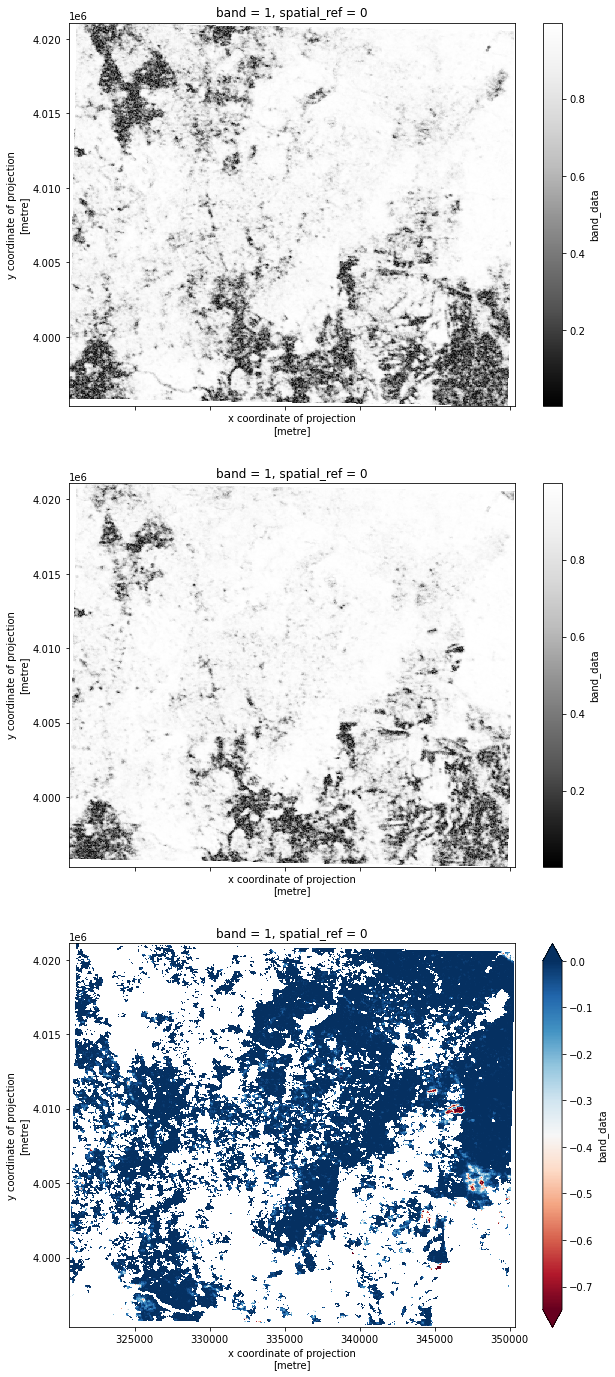

In [119]:
fig, ax = plt.subplots(3,1, figsize=(10,24), sharex=True)

mask = pre_proj['band_data'] < 0.8

pre_proj['band_data'].plot(cmap='Greys_r', ax = ax[0])
post_proj['band_data'].plot(cmap='Greys_r', ax = ax[1])

dif.where(pre_proj > 0.9)['band_data'].plot(cmap='RdBu', ax = ax[2], vmin = -.75, vmax = 0)

#dif.plot(cmap='RdBu', ax = ax[2], vmin = -.75, vmax = 0)
#dif_mask.where(dif_mask ==0).plot(cmap='RdBu', ax = ax[2], vmin = -.75, vmax = 0)

# for a in ax:
#     a.set_xlim(37.08, 37.22)
#     a.set_ylim(36.13, 36.26)
    
#plt.savefig(os.path.join(fig_dir, 'example_aleppo.png'), dpi=300, facecolor='white')

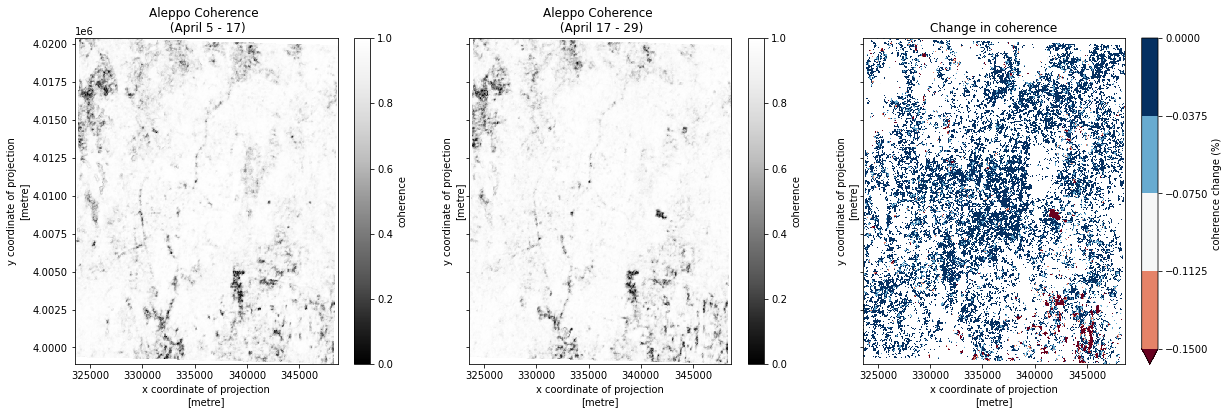

In [240]:
#Plot all of the data!

fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey = True)

im1 =  pre.band_data.plot(ax = ax[0], cmap='Greys_r', vmin = 0, vmax = 1, label = 'test')
im2 = post.band_data.plot(ax = ax[1], cmap='Greys_r', vmin = 0, vmax = 1)
im3 = dif.band_data.plot(ax = ax[2], vmin = -.15, vmax = 0, levels = 5, cmap = 'RdBu')

ax[0].set_title('Aleppo Coherence \n (April 5 - 17)')
ax[1].set_title('Aleppo Coherence \n (April 17 - 29)')
ax[2].set_title('Change in coherence')

im1.colorbar.set_label('coherence')
im2.colorbar.set_label('coherence')
im3.colorbar.set_label('coherence change (%)')

plt.savefig(os.path.join(fig_dir, 'aleppo_example.png'), dpi=300, facecolor='white')